In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import netCDF4 as nc
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools, places
import gsw
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.dates as mdates
import cmocean as cmo
from matplotlib.colors import LogNorm
#import scipy.io as so

mpl.rc('xtick', labelsize=10)
mpl.rc('ytick', labelsize=10)
mpl.rc('legend', fontsize=10)
mpl.rc('axes', titlesize=10)
mpl.rc('axes', labelsize=10)
mpl.rc('figure', titlesize=10)
mpl.rc('font', size=10)
%matplotlib inline

note: salinity not available to convert t to CT, so converted model CT to t

In [2]:
chlToN=1.6
indj,indi=places.PLACES['Halibut Bank']['NEMO grid ji']
indk=0

In [3]:
datelims=(dt.datetime(1900,1,1),dt.datetime(2100,1,1))
start_date=datelims[0]
end_date=datelims[1]
hblat=49.34
hblon=-123.72
hbz=1.0

In [4]:
f2 = pd.read_excel('/ocean/shared/SalishSeaCastData/SOGDC/HalibutBankBuoy/HB-2015 Fluorometer.xlsx',
                 sheet_name = '201502',skiprows=7,header=None,names=['datetime','fluor','Turb','Temp'],
                  dtype={0:str,1:float,2:float,3:float})
f4 = pd.read_excel('/ocean/shared/SalishSeaCastData/SOGDC/HalibutBankBuoy/HB-2015 Fluorometer.xlsx',
                 sheet_name = '201504',skiprows=7,header=None,names=['datetime','fluor','Turb','Temp'],
                  dtype={0:str,1:float,2:float,3:float})
f6 = pd.read_excel('/ocean/shared/SalishSeaCastData/SOGDC/HalibutBankBuoy/HB-2015 Fluorometer.xlsx',
                 sheet_name = '201506',skiprows=7,header=None,names=['datetime','fluor','Turb','Temp'],
                  dtype={0:str,1:float,2:float,3:float})

In [5]:
df=pd.concat([f2,f4,f6],ignore_index=True)
print(df['datetime'].values[0])

2015-02-01 00:54:39


In [6]:
dts=[dt.datetime.strptime(ii,'%Y-%m-%d %H:%M:%S') for ii in df['datetime'].values]
df['dtUTC']=dts

In [7]:
df.head()

,datetime,fluor,Turb,Temp,dtUTC
0,2015-02-01 00:54:39,1.6765,0.33180,7.54972,2015-02-01 00:54:39
1,2015-02-01 01:24:41,1.8585,0.28440,7.50380,2015-02-01 01:24:41
2,2015-02-01 01:54:43,1.9495,0.28440,7.50380,2015-02-01 01:54:43
3,2015-02-01 02:24:45,1.8410,0.32232,7.46796,2015-02-01 02:24:45
4,2015-02-01 02:54:47,1.8725,0.28440,7.45676,2015-02-01 02:54:47


In [8]:
# load extracted Halibut Bank model results
dirs=('hindcast2015','hindcast2015P')
#dirnames=('spring2015_NewSink','spring2015_slowPP','spring2015_KhT','spring2015_diatHS')
varNameDict={'Halibut Bank':'HalibutBank','Sentry Shoal':'SentryShoal', 'S3':'S3', 'Central node':'CentralNode', 'Central SJDF':'CentralSJDF'}
plist=('Halibut Bank',)
with open('/ocean/eolson/MEOPAR/analysis-elise/notebooks/bioTuning/spathsMaster.txt') as f:
    spaths = dict(x.strip().split() for x in f)
ff=dict()
for idir in dirs:
    ff[idir]=dict()
    for pl in plist:
        print(spaths[idir]+'ts_'+idir+'_'+varNameDict[pl]+'.nc')
        ff[idir][pl]=nc.Dataset(spaths[idir]+'ts_'+idir+'_'+varNameDict[pl]+'.nc')


/data/eolson/results/MEOPAR/SS36runs/calcFiles/comparePhytoN/ts_hindcast2015_HalibutBank.nc
/data/eolson/results/MEOPAR/SS36runs/calcFiles/comparePhytoN/ts_hindcast2015P_HalibutBank.nc


In [9]:
torig=dt.datetime.strptime(ff[idir][plist[0]].variables['time_centered'].time_origin,'%Y-%m-%d %H:%M:%S')
dtMod=np.array([torig + dt.timedelta(seconds=ii) for ii in ff[idir][plist[0]].variables['time_centered'][:]])

In [10]:
f=ff['hindcast2015']['Halibut Bank']
fp=ff['hindcast2015P']['Halibut Bank']

In [11]:
with nc.Dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/mesh_mask201702.nc') as mesh:
    deptht=mesh.variables['gdept_1d'][0,:]

In [12]:

mod_t=np.nan*np.ones(np.shape(fp.variables['votemper']))
for iit in range(0,np.shape(mod_t)[0]):
    for iik in range(0,np.shape(mod_t)[1]):
        mod_t[iit,iik,0,0]=gsw.t_from_CT(fp.variables['vosaline'][iit,iik,0,0],
                                         fp.variables['votemper'][iit,iik,0,0],
                                        gsw.p_from_z(deptht[iik],hblat))

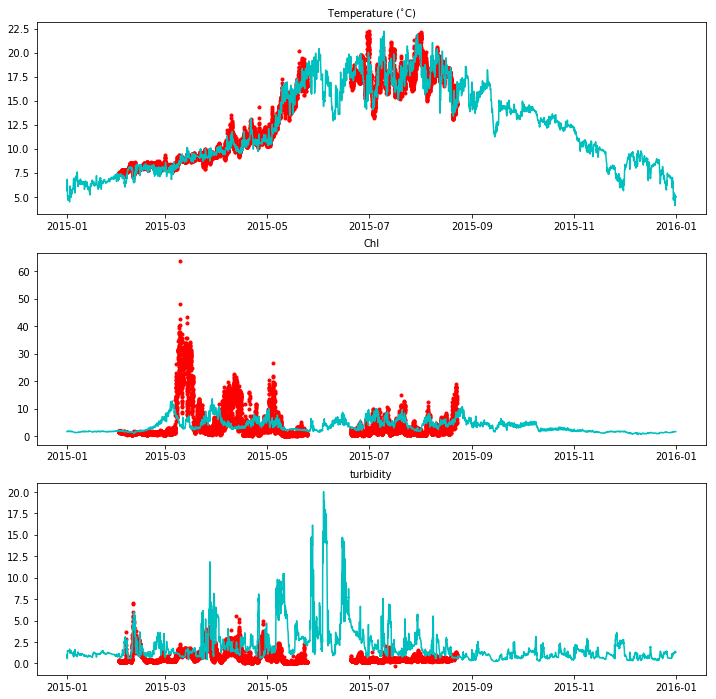

In [13]:
fig,ax=plt.subplots(3,1,figsize=(12,12))

ax[0].plot(df['dtUTC'],df['Temp'],'r.')
##var=np.sum(fp.variables['votemper'][:,:2,0,0]*fp.variables['e3t'][:,:2,0,0],1)/np.sum(fp.variables['e3t'][:,:2,0,0],1)
#var=fp.variables['votemper'][:,0,0,0]
var=mod_t[:,0,0,0]
ax[0].plot(dtMod,var,'c-')
ax[0].set_title('Temperature ($^{\circ}$C)')

ax[1].plot(df['dtUTC'],df['fluor'],'r.')
#var=chlToN*np.sum((f.variables['diatoms'][:,:2,0,0]+f.variables['ciliates'][:,:2,0,0]+f.variables['flagellates'][:,:2,0,0])*f.variables['e3t'][:,:2,0,0],1)/np.sum(f.variables['e3t'][:,:2,0,0],1)
var=chlToN*(f.variables['diatoms'][:,0,0,0]+f.variables['ciliates'][:,0,0,0]+f.variables['flagellates'][:,0,0,0])
ax[1].plot(dtMod,var,'c-')
ax[1].set_title('Chl')

ax[2].plot(df['dtUTC'],df['Turb'],'r.')
#var=np.sum(f.variables['Fraser_tracer'][:,:2,0,0]*f.variables['e3t'][:,:2,0,0],1)/np.sum(f.variables['e3t'][:,:2,0,0],1)
var=fp.variables['Fraser_tracer'][:,0,0,0]
ax[2].plot(dtMod,var,'c-')
ax[2].set_title('turbidity')

In [14]:
fid={'Bio':ff['hindcast2015']['Halibut Bank'],'Phys':ff['hindcast2015P']['Halibut Bank']}
filemap={'diatoms':'Bio','ciliates':'Bio','flagellates':'Bio','Fraser_tracer':'Phys',
         'votemper':'Phys','vosaline':'Phys'}
ftypes=list(set(filemap.values()))
# reverse filemap dict
filemap_r=dict()
for ift in ftypes:
    filemap_r[ift]=list()
for ikey in filemap:
    filemap_r[filemap[ikey]].append(ikey)

# set up columns to accept model values
for ivar in filemap.keys():
    df['mod_'+ivar]=np.full(len(df),np.nan)

for ind, row in df.iterrows():
    for ift in ftypes:
        # find time index
        indh=et._getTimeInd_bin(row['dtUTC'],fid[ift],torig)
        # assign values for each var assoc with ift
        if not np.isnan(indk):
            for ivar in filemap_r[ift]:
                df.loc[ind,['mod_'+ivar]]=fid[ift].variables[ivar][indh,indk,0,0]
df['mod_Chl']=chlToN*(df['mod_diatoms']+df['mod_ciliates']+df['mod_flagellates'])

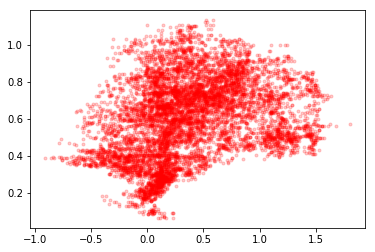

In [15]:
plt.plot(np.log10(df['fluor']+.01),np.log10(df['mod_Chl']+.01),'r.',alpha=.2)

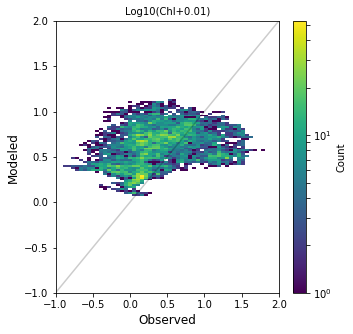

In [16]:
data=df
fig,ax=plt.subplots(1,1,figsize=(5,5))
iiCh=(~np.isnan(data['fluor']))&(~np.isnan(data['mod_Chl']))
counts, xedges, yedges, m1=ax.hist2d(np.log10(data.loc[iiCh,['fluor']].values.flatten()+.01),
                                      np.log10(data.loc[iiCh,['mod_Chl']].values.flatten()+.01),bins=25*2,norm=LogNorm())

ax.plot((-1,2),(-1,2),'k-',alpha=.2)
cb=fig.colorbar(m1)#,cax=axcb
cb.set_label('Count')
ax.set_xlim(-1,2)
ax.set_ylim(-1,2)

ax.set_ylabel('Modeled',fontsize=12)
ax.set_xlabel('Observed',fontsize=12)
ax.set_title('Log10(Chl+0.01)')

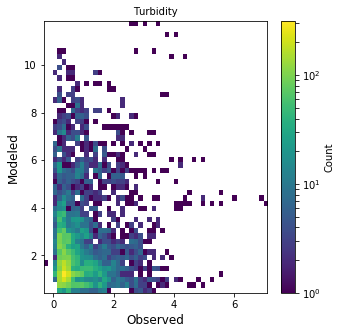

In [17]:
fig,ax=plt.subplots(1,1,figsize=(5,5))
iiTu=(~np.isnan(data['Turb']))&(~np.isnan(data['mod_Fraser_tracer']))
counts, xedges, yedges, m1=ax.hist2d(data.loc[iiCh,['Turb']].values.flatten(),
                                      data.loc[iiCh,['mod_Fraser_tracer']].values.flatten(),bins=25*2,norm=LogNorm())

#ax.plot((-1,2),(-1,2),'k-',alpha=.2)
cb=fig.colorbar(m1)#,cax=axcb
cb.set_label('Count')
#ax.set_xlim(-1,2)
#ax.set_ylim(-1,2)

ax.set_ylabel('Modeled',fontsize=12)
ax.set_xlabel('Observed',fontsize=12)
ax.set_title('Turbidity')

In [18]:
data.keys()
p=gsw.p_from_z(1.0,hblat)
data['mod_Temp']=[gsw.t_from_CT(iisa,iict,p) for iisa,iict in zip(data['mod_vosaline'],data['mod_votemper'])]

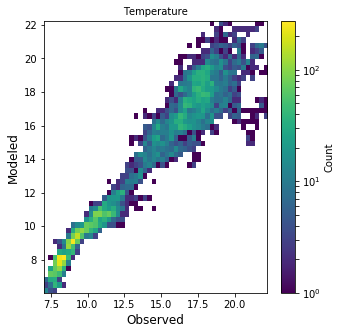

In [19]:
fig,ax=plt.subplots(1,1,figsize=(5,5))
iiT=(~np.isnan(data['Temp']))&(~np.isnan(data['mod_Temp']))
counts, xedges, yedges, m1=ax.hist2d(data.loc[iiT,['Temp']].values.flatten(),
                                      data.loc[iiT,['mod_Temp']].values.flatten(),bins=25*2,norm=LogNorm())

#ax.plot((-1,2),(-1,2),'k-',alpha=.2)
cb=fig.colorbar(m1)#,cax=axcb
cb.set_label('Count')
#ax.set_xlim(-1,2)
#ax.set_ylim(-1,2)

ax.set_ylabel('Modeled',fontsize=12)
ax.set_xlabel('Observed',fontsize=12)
ax.set_title('Temperature')